## Updated Phase Out Plots (correct SCC 190), (only 3 i.e. removed without maturity b/c)

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/2007052069.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/2007052069.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/2007052069.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


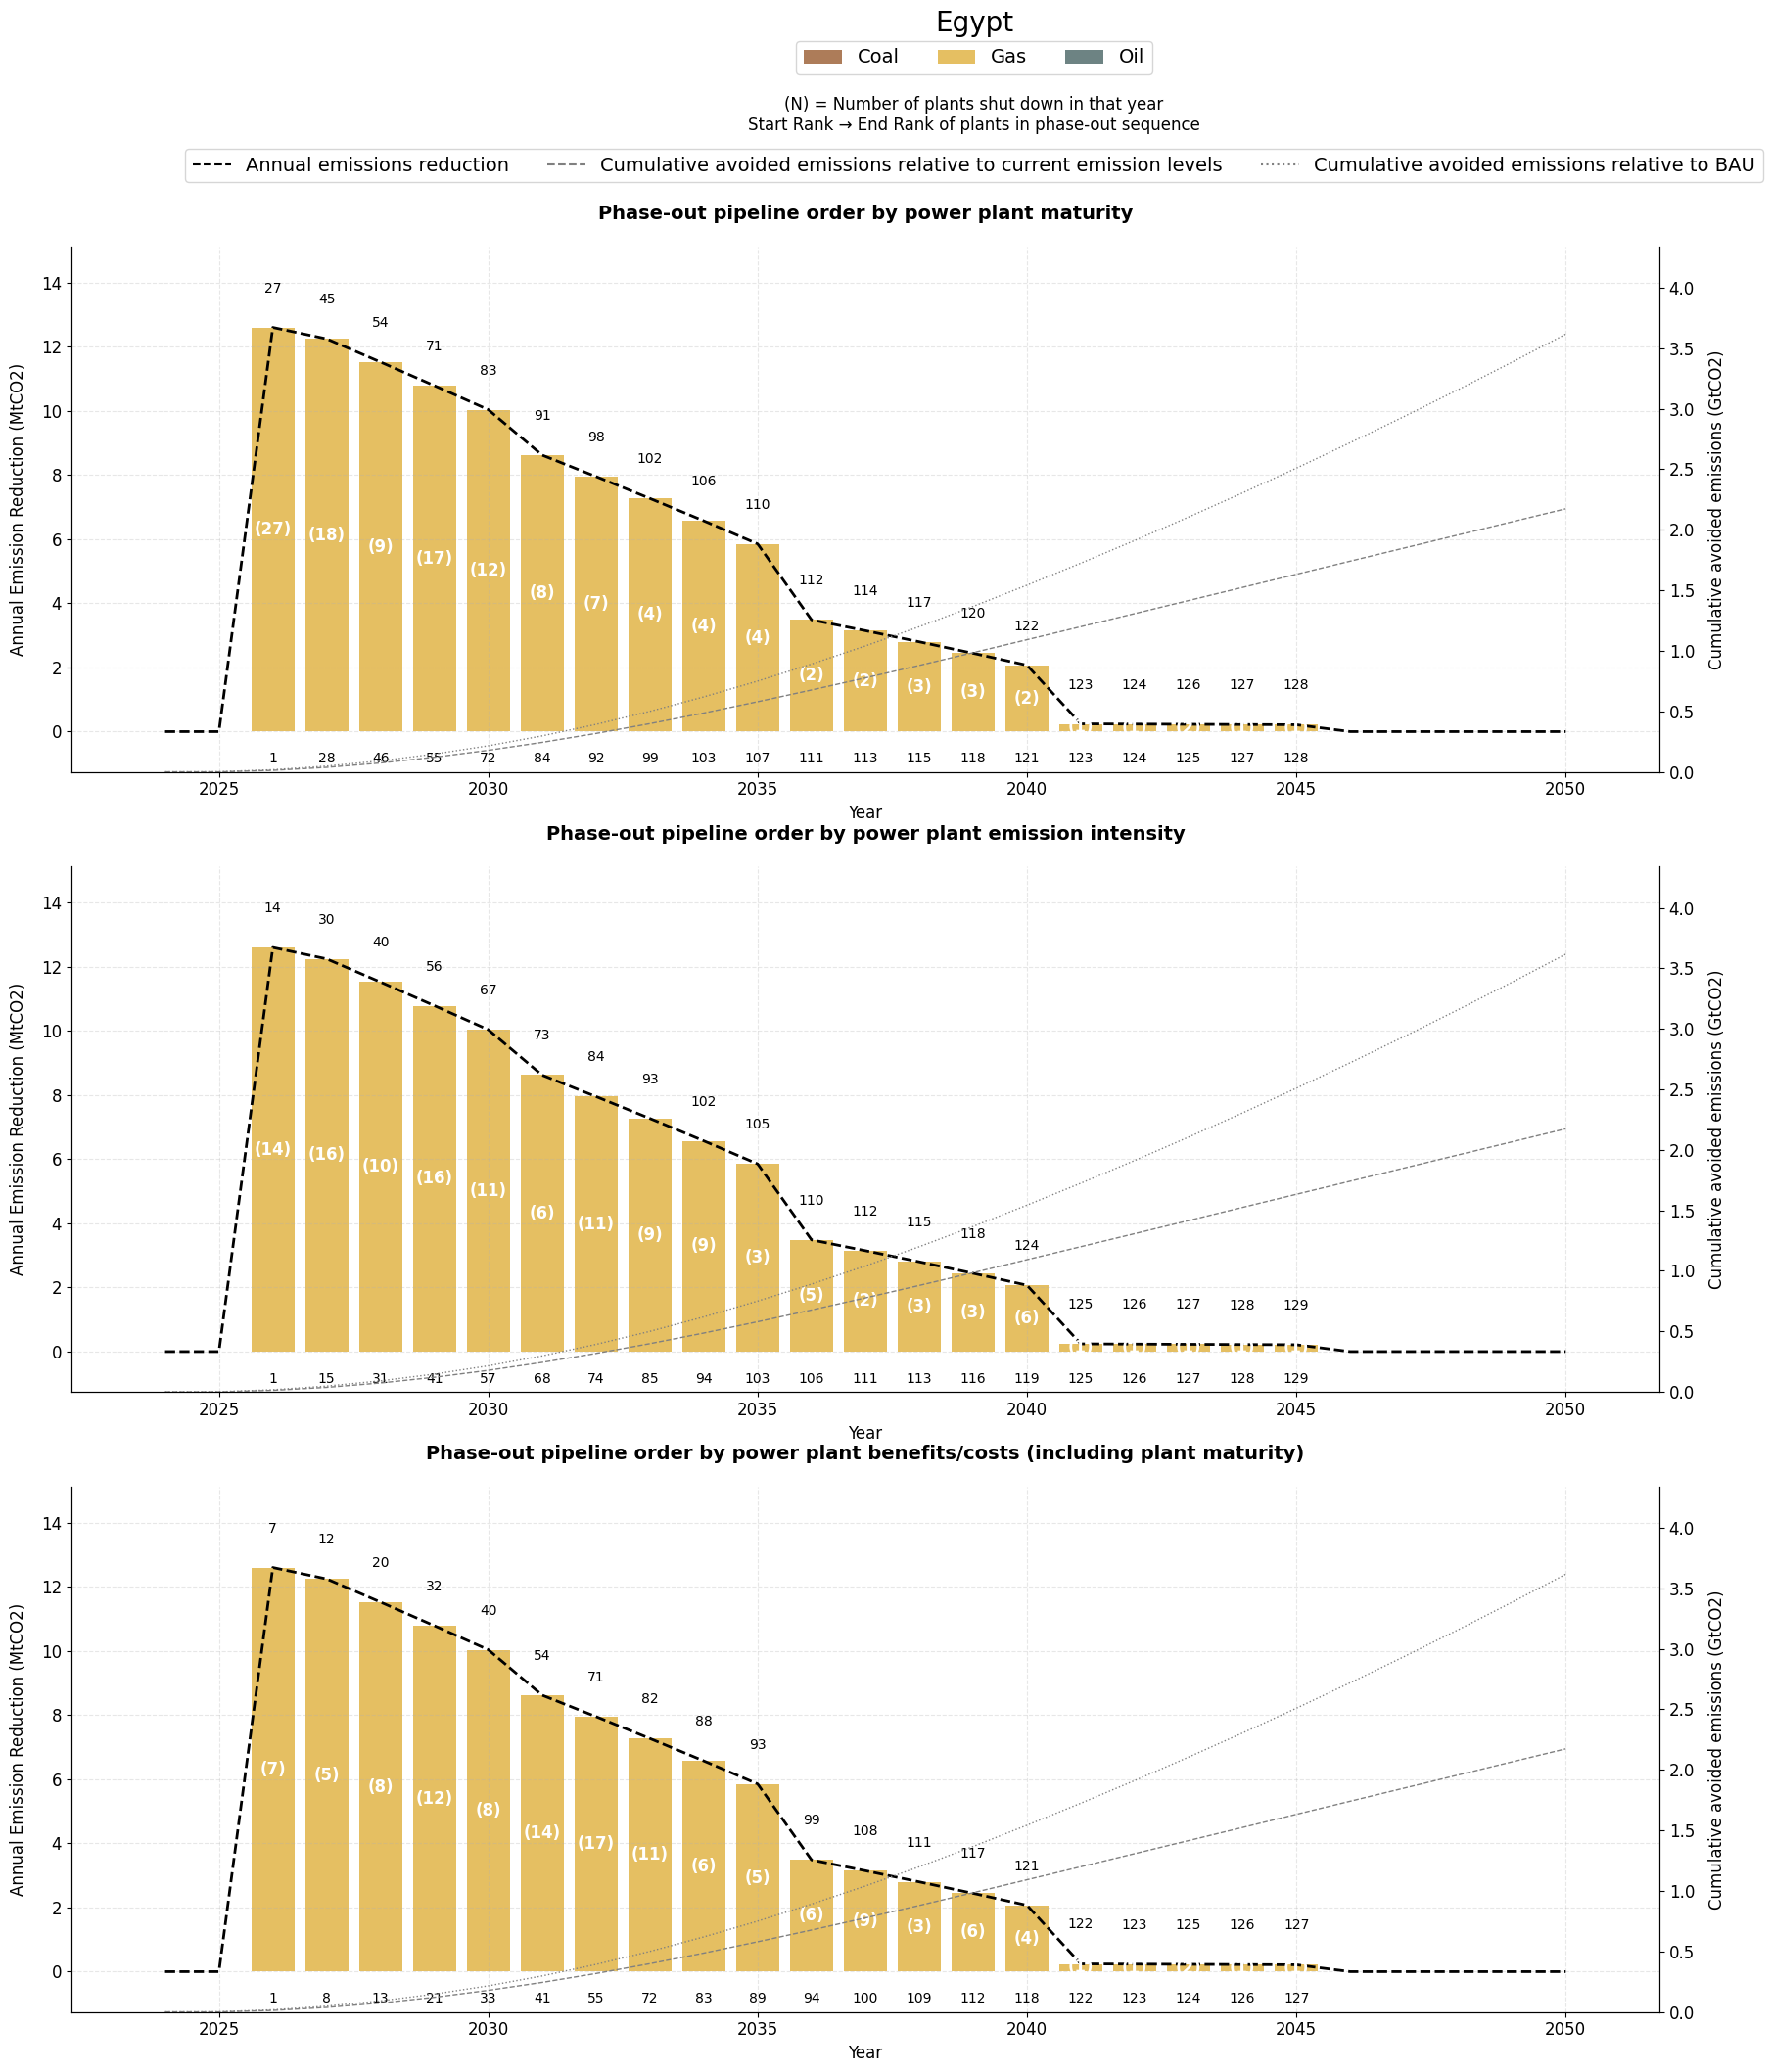

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def load_scenario_data(path):
    df = pd.read_csv(path)
    year_cols = [str(year) for year in range(2024, 2051)]
    
    scenario_data = {}
    for country in df['Region'].unique():
        country_data = df[df['Region'] == country]
        yearly_totals = {}
        
        for year in year_cols:
            year_total = country_data[year].sum()
            yearly_totals[int(year)] = year_total
                
        scenario_data[country] = yearly_totals
    
    return scenario_data

def load_and_process_data(base_path, country_code):
    files = {
        'maturity': f'v2_power_plant_phaseout_order_by_maturity_{country_code}_2050.csv',
        'emission_factor': f'v2_power_plant_phaseout_order_by_emission_factor_{country_code}_2050.csv',
        'benefits_cost_maturity': f'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_{country_code}_2050.csv'
    }
    
    dfs = {}
    for key, filename in files.items():
        file_path = Path(base_path) / filename
        df = pd.read_csv(file_path)
        
        annual_data = []
        current_rank = 1
        cumulative_emissions = 0
        
        available_years = sorted(df['year'].unique())
        all_years = list(range(2024, 2051))
        
        for year in all_years:
            if year in available_years:
                year_plants = df[df['year'] == year]
                n_plants = len(year_plants)
                year_emissions = year_plants['amount_mtco2'].sum()
                cumulative_emissions += year_emissions
                
                annual_data.append({
                    'year': year,
                    'amount_mtco2': year_emissions,
                    'cumulative_mtco2': cumulative_emissions,
                    'start_rank': current_rank,
                    'end_rank': current_rank + n_plants - 1,
                    'n_plants': n_plants,
                    'plants_by_subsector': year_plants.groupby('subsector')['amount_mtco2'].sum().to_dict()
                })
                current_rank += n_plants
            else:
                annual_data.append({
                    'year': year,
                    'amount_mtco2': 0,
                    'cumulative_mtco2': cumulative_emissions,
                    'start_rank': current_rank,
                    'end_rank': current_rank,
                    'n_plants': 0,
                    'plants_by_subsector': {'Coal': 0, 'Gas': 0, 'Oil': 0}
                })
        
        dfs[key] = pd.DataFrame(annual_data)
    
    return dfs

def create_visualization(country_code, country_name, base_path, bau_path, scenario_path):
    bau_data = load_scenario_data(bau_path)['EGY' if country_code == 'EG' else 'BGD']
    scenario_data = load_scenario_data(scenario_path)['EGY' if country_code == 'EG' else 'BGD']
    
    dfs = load_and_process_data(base_path, country_code)
    
    # Changed from 4,1 to 3,1 and adjusted figure size
    fig, axes = plt.subplots(3, 1, figsize=(20, 22))
    
    titles = {
        'maturity': 'Phase-out pipeline order by power plant maturity',
        'emission_factor': 'Phase-out pipeline order by power plant emission intensity',
        'benefits_cost_maturity': 'Phase-out pipeline order by power plant benefits/costs (including plant maturity)'
    }
    
    colors = {'Coal': '#8B4513', 'Gas': '#DAA520', 'Oil': '#2F4F4F'}
    
    fig.suptitle(country_name, fontsize=20, y=0.96)
    
    fuel_patches = [plt.Rectangle((0,0), 1, 1, facecolor=colors[fuel], alpha=0.7) 
                   for fuel in ['Coal', 'Gas', 'Oil']]
    
    line_patches = [
        plt.Line2D([0], [0], color='black', linestyle='--'),
        plt.Line2D([0], [0], color='grey', linestyle='--'),
        plt.Line2D([0], [0], color='grey', linestyle=':')
    ]
    
    fig.legend(fuel_patches, ['Coal', 'Gas', 'Oil'],
              loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)
    
    fig.text(0.5, 0.92, '(N) = Number of plants shut down in that year\nStart Rank → End Rank of plants in phase-out sequence',
             fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    fig.legend(line_patches, 
              ['Annual emissions reduction',
               'Cumulative avoided emissions relative to current emission levels',
               'Cumulative avoided emissions relative to BAU'],
              loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=5, fontsize=14)
    
    for idx, (key, df) in enumerate(dfs.items()):
        ax = axes[idx]
        ax2 = ax.twinx()
        
        years = list(range(2024, 2051))
        max_emissions = df['amount_mtco2'].max()
        min_val = -max_emissions*0.1
        
        annual_totals = df['amount_mtco2'].values
        ax.plot(years, annual_totals, 'k--', linewidth=2)
        
        for i, row in df.iterrows():
            bottom = 0
            for subsector, amount in row['plants_by_subsector'].items():
                ax.bar(row['year'], amount, bottom=bottom, 
                      color=colors[subsector], alpha=0.7)
                bottom += amount
            
            total_height = sum(row['plants_by_subsector'].values())
            
            if total_height > 0:
                ax.text(row['year'], min_val*0.5,
                       f'{row["start_rank"]}', 
                       ha='center', va='top',
                       fontsize=10)
                ax.text(row['year'], total_height + max_emissions*0.08, 
                       f'{row["end_rank"]}', 
                       ha='center', va='bottom',
                       fontsize=10)
                ax.text(row['year'], total_height/2, 
                       f'({row["n_plants"]})',
                       ha='center', va='center', 
                       color='white', 
                       fontweight='bold', fontsize=12)
        
        cumulative_from_2024 = []
        for year in years:
            if year == 2024:
                cumulative_from_2024.append(0)
            else:
                total_diff = sum(scenario_data[2024] - scenario_data[y] for y in range(2024, year + 1))
                cumulative_from_2024.append(total_diff)
        
        cumulative_bau_scenario = []
        for year in years:
            if year == 2024:
                cumulative_bau_scenario.append(0)
            else:
                bau_sum = sum(bau_data[y] for y in range(2024, year + 1))
                scenario_sum = sum(scenario_data[y] for y in range(2024, year + 1))
                year_difference = (bau_sum - scenario_sum)
                cumulative_bau_scenario.append(year_difference)
        
        ax2.plot(years, cumulative_from_2024, color='grey', linestyle='--', linewidth=1)
        ax2.plot(years, cumulative_bau_scenario, color='grey', linestyle=':', linewidth=1)
        
        ax.set_title(titles[key], pad=20, fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Annual Emission Reduction (MtCO2)', fontsize=12, labelpad=10)
        ax2.set_ylabel('Cumulative avoided emissions (GtCO2)', fontsize=12, labelpad=10)
        
        y2_ticks = ax2.get_yticks()
        ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
        
        max_cumulative = max(max(cumulative_from_2024), max(cumulative_bau_scenario))
        
        ax.set_ylim(min_val, max_emissions*1.2)
        ax2.set_ylim(min_val, max_cumulative*1.2)
        
        ax.tick_params(axis='both', labelsize=12)
        ax2.tick_params(axis='both', labelsize=12)
        
        ax.set_xticks(np.arange(2025, 2055, 5))
        ax.set_xticklabels([str(year) for year in range(2025, 2055, 5)])
        
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        
        ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right=0.85)
    return fig

base_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data"
bau_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Scenarios Files/annual BAU .csv"
scenario_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Scenarios Files/Annual 1.5 50.csv"

fig_egypt = create_visualization('EG', 'Egypt', base_path, bau_path, scenario_path)
plt.show()

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def load_scenario_data(path):
    df = pd.read_csv(path)
    year_cols = [str(year) for year in range(2024, 2051)]
    
    scenario_data = {}
    for country in df['Region'].unique():
        country_data = df[df['Region'] == country]
        yearly_totals = {}
        
        for year in year_cols:
            year_total = country_data[year].sum()
            yearly_totals[int(year)] = year_total
                
        scenario_data[country] = yearly_totals
    
    return scenario_data

def load_and_process_data(base_path, country_code):
    files = {
        'maturity': f'v2_power_plant_phaseout_order_by_maturity_{country_code}_2050.csv',
        'emission_factor': f'v2_power_plant_phaseout_order_by_emission_factor_{country_code}_2050.csv',
        'benefits_cost_maturity': f'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_{country_code}_2050.csv'
    }
    
    dfs = {}
    for key, filename in files.items():
        file_path = Path(base_path) / filename
        df = pd.read_csv(file_path)
        
        annual_data = []
        current_rank = 1
        cumulative_emissions = 0
        
        for year in sorted(df['year'].unique()):
            year_plants = df[df['year'] == year]
            n_plants = len(year_plants)
            year_emissions = year_plants['amount_mtco2'].sum()
            cumulative_emissions += year_emissions
            
            annual_data.append({
                'year': year,
                'amount_mtco2': year_emissions,
                'cumulative_mtco2': cumulative_emissions,
                'start_rank': current_rank,
                'end_rank': current_rank + n_plants - 1,
                'n_plants': n_plants,
                'plants_by_subsector': year_plants.groupby('subsector')['amount_mtco2'].sum().to_dict()
            })
            current_rank += n_plants
        
        dfs[key] = pd.DataFrame(annual_data)
    
    return dfs

def create_annual_visualization(dfs, country_name, bau_data, scenario_data):
    fig, axes = plt.subplots(3, 1, figsize=(20, 22))
    
    titles = {
        'maturity': 'Phase-out pipeline order by power plant maturity',
        'emission_factor': 'Phase-out pipeline order by power plant emission intensity',
        'benefits_cost_maturity': 'Phase-out pipeline order by power plant benefits/costs (including plant maturity)'
    }
    
    colors = {'Coal': '#8B4513', 'Gas': '#DAA520', 'Oil': '#2F4F4F'}
    
    fig.suptitle(country_name, fontsize=20, y=0.96)
    
    fuel_patches = [plt.Rectangle((0,0), 1, 1, facecolor=colors[fuel], alpha=0.7) 
                   for fuel in ['Coal', 'Gas', 'Oil']]
    
    line_patches = [
        plt.Line2D([0], [0], color='black', linestyle='--'),
        plt.Line2D([0], [0], color='grey', linestyle='--'),
        plt.Line2D([0], [0], color='grey', linestyle=':')
    ]
    
    fig.legend(fuel_patches, ['Coal', 'Gas', 'Oil'],
              loc='upper center', 
              bbox_to_anchor=(0.5, 0.95),
              ncol=3, fontsize=14)
    
    explanation_text = (
        '(N) = Number of plants shut down in that year\n'
        'Start Rank → End Rank of plants in phase-out sequence'
    )
    fig.text(0.5, 0.92, explanation_text,
             fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    fig.legend(line_patches, 
              ['Annual emissions reduction',
               'Cumulative avoided emissions relative to current emission levels',
               'Cumulative avoided emissions relative to BAU'],
              loc='upper center',
              bbox_to_anchor=(0.5, 0.9),
              ncol=5, fontsize=14)

    for idx, (key, df) in enumerate(dfs.items()):
        ax = axes[idx]
        ax2 = ax.twinx()
        
        years = sorted(df['year'].unique())
        max_emissions = df['amount_mtco2'].max()
        min_val = -max_emissions*0.1
        
        annual_totals = [df[df['year'] == year]['amount_mtco2'].sum() for year in years]
        ax.plot(years, annual_totals, 'k--', linewidth=2)
        
        for i, row in df.iterrows():
            bottom = 0
            for subsector, amount in row['plants_by_subsector'].items():
                ax.bar(row['year'], amount, bottom=bottom, 
                      color=colors[subsector], alpha=0.7)
                bottom += amount
            
            total_height = sum(row['plants_by_subsector'].values())
            
            ax.text(row['year'], min_val*0.5,
                   f'{row["start_rank"]}', 
                   ha='center', va='top',
                   fontsize=10)
            ax.text(row['year'], total_height + max_emissions*0.08, 
                   f'{row["end_rank"]}', 
                   ha='center', va='bottom',
                   fontsize=10)
            
            if total_height > 0:
                ax.text(row['year'], total_height/2, 
                       f'({row["n_plants"]})',
                       ha='center', va='center', 
                       color='white', 
                       fontweight='bold', fontsize=12)
        
        # Calculate cumulative difference from 2024 levels for scenario pathway
        cumulative_from_2024 = []
        for year in years:
            if year == 2024:
                cumulative_from_2024.append(0)
            else:
                total_diff = sum(scenario_data[2024] - scenario_data[y] for y in range(2024, year + 1))
                cumulative_from_2024.append(total_diff)
        
        # Calculate cumulative BAU vs scenario difference
        cumulative_bau_scenario = []
        for year in years:
            if year == 2024:
                cumulative_bau_scenario.append(0)
            else:
                bau_sum = sum(bau_data[y] for y in range(2024, year + 1))
                scenario_sum = sum(scenario_data[y] for y in range(2024, year + 1))
                year_difference = (bau_sum - scenario_sum)
                cumulative_bau_scenario.append(year_difference)
        
        ax2.plot(years, cumulative_from_2024, color='grey', linestyle='--', linewidth=1)
        ax2.plot(years, cumulative_bau_scenario, color='grey', linestyle=':', linewidth=1)
        
        ax.set_title(titles[key], pad=20, fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Annual Emission Reduction (MtCO2)', fontsize=12, labelpad=10)
        ax2.set_ylabel('Cumulative avoided emissions (GtCO2)', fontsize=12, labelpad=10)
        
        y2_ticks = ax2.get_yticks()
        ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
        
        max_cumulative = max(max(cumulative_from_2024), max(cumulative_bau_scenario))
        
        ax.set_ylim(min_val, max_emissions*1.2)
        ax2.set_ylim(min_val, max_cumulative*1.2)
        
        def get_display_coord(ax, value):
            return ax.transData.transform((0, value))[1]
        
        while abs(get_display_coord(ax, 0) - get_display_coord(ax2, 0)) > 1:
            ax2_pos = get_display_coord(ax2, 0)
            ax_pos = get_display_coord(ax, 0)
            current_min, current_max = ax2.get_ylim()
            
            if ax2_pos < ax_pos:
                ax2.set_ylim(current_min*1.01, current_max)
            else:
                ax2.set_ylim(current_min*0.99, current_max)
        
        ax.tick_params(axis='both', labelsize=12)
        ax2.tick_params(axis='both', labelsize=12)
        
        ax.set_xticks(np.arange(2025, 2055, 5))
        ax.set_xticklabels([str(year) for year in range(2025, 2055, 5)])
        
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        
        ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right=0.85)
    return fig

def save_visualization(fig, country_name, output_dir):
    output_dir = Path(output_dir) / "v4 phase out plots"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"{country_name.replace(' ', '')}PhaseOutOrder.png"
    print(f"Saving to: {output_path}")
    fig.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close(fig)

if __name__ == "__main__":
    base_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data"
    bau_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Scenarios Files/annual BAU .csv"
    scenario_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Scenarios Files/Annual 1.5 50.csv"
    output_dir = Path(base_path).parent
    
    iso_mapping = {
        'IN': 'IND', 'ID': 'IDN', 'ZA': 'ZAF', 'MX': 'MEX', 
        'VN': 'VNM', 'IR': 'IRN', 'TH': 'THA', 'EG': 'EGY', 
        'TR': 'TUR', 'BD': 'BGD'
    }
    
    bau_processed = load_scenario_data(bau_path)
    scenario_processed = load_scenario_data(scenario_path)
    
    countries = ['IN', 'ID', 'ZA', 'MX', 'VN', 'IR', 'TH', 'EG', 'TR', 'BD']
    country_names = {
        'IN': 'India', 'ID': 'Indonesia', 'ZA': 'South Africa',
        'MX': 'Mexico', 'VN': 'Vietnam', 'IR': 'Iran', 
        'TH': 'Thailand', 'EG': 'Egypt', 'TR': 'Türkiye', 
        'BD': 'Bangladesh'
    }

    for country in countries:
        print(f"\nProcessing {country_names[country]}...")
        dfs = load_and_process_data(base_path, country)
        fig = create_annual_visualization(dfs, country_names[country], 
                                       bau_processed[iso_mapping[country]],
                                       scenario_processed[iso_mapping[country]])
        save_visualization(fig, country_names[country], output_dir)
        print(f"Saved plot for {country_names[country]}")


Processing India...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/IndiaPhaseOutOrder.png
Saved plot for India

Processing Indonesia...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/IndonesiaPhaseOutOrder.png
Saved plot for Indonesia

Processing South Africa...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/SouthAfricaPhaseOutOrder.png
Saved plot for South Africa

Processing Mexico...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/MexicoPhaseOutOrder.png
Saved plot for Mexico

Processing Vietnam...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/VietnamPhaseOutOrder.png
Saved plot for Vietnam

Processing Iran...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/IranPhaseOutOrder.png
Saved plot for Iran

Processing Thailand...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/ThailandPhaseOutOrder.png
Saved plot for Thailand

Processing Egypt...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/955092260.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])


Saving to: /Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v4 phase out plots/EgyptPhaseOutOrder.png
Saved plot for Egypt

Processing Türkiye...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/v2_power_plant_phaseout_order_by_maturity_TR_2050.csv'

# removed the yellow so that it does not 

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

layout_settings = {
   'IND': {
       'colorbar': {'x': 0.75, 'y': 0.22, 'width': 0.02, 'height': 0.2},
       'legend': {'x': 0.7, 'y': 0.45},
       'note': {'x': 0.5, 'y': 0.05}
   },
   'IDN': {
       'colorbar': {'x': 0.065, 'y': 0.33, 'width': 0.018, 'height': 0.14},
       'legend': {'x': 1, 'y': 0.95},
       'note': {'x': 0.5, 'y': 0.67}
   },
   'MEX': {
       'colorbar': {'x': 0.07, 'y': 0.33, 'width': 0.018, 'height': 0.2},
       'legend': {'x': 1, 'y': 0.97},
       'note': {'x': 0.5, 'y': 0.79}
   },
   'EGY': {
       'colorbar': {'x': 0.2, 'y': 0.33, 'width': 0.018, 'height': 0.2},
       'legend': {'x': 1, 'y': 0.97},
       'note': {'x': 0.5, 'y': 0.03}
   },
   'THA': {
       'colorbar': {'x': 0.67, 'y': 0.23, 'width': 0.018, 'height': 0.2},
       'legend': {'x': 1, 'y': 0.97},
       'note': {'x': 0.635, 'y': 0.02}
   },
   'ZAF': {
       'colorbar': {'x': 0.9, 'y': 0.1, 'width': 0.02, 'height': 0.25},
       'legend': {'x': 0.12, 'y': 0.97},
       'note': {'x': 0.5, 'y': 0.1}
   },
   'VNM': {
       'colorbar': {'x': 0.35, 'y': 0.35, 'width': 0.018, 'height': 0.25},
       'legend': {'x': 1, 'y': 1},
       'note': {'x': 0.5, 'y': 0.02}
   },
   'IRN': {
       'colorbar': {'x': 0.1, 'y': 0.15, 'width': 0.018, 'height': 0.25},
       'legend': {'x': 1, 'y': 1},
       'note': {'x': 0.5, 'y': 0.08}
   }
}

def load_merge_data(phase_file, country_iso3):
   df_phase = pd.read_csv(phase_file)
   df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)
   df_forward_country = df_forward[df_forward['countryiso3'] == country_iso3]
   
   df_merged = df_phase.merge(
       df_forward_country[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude']], 
       on=['asset_name', 'uniqueforwardassetid'],
       how='left'
   )
   
   np.random.seed(42)
   jitter_scale = 0.03
   df_merged['longitude'] = df_merged['longitude'] + np.random.normal(0, jitter_scale, len(df_merged))
   df_merged['latitude'] = df_merged['latitude'] + np.random.normal(0, jitter_scale, len(df_merged))
   
   return df_merged

def create_phaseout_map(df_merged, title, country_iso3):
   shapefile_path = f'/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_{country_iso3}_shp/gadm41_{country_iso3}_1.shp'
   country = gpd.read_file(shapefile_path)

   fig, ax = plt.subplots(figsize=(15, 15))
   country.plot(ax=ax, color='white', edgecolor='grey')

   markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
   sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

   for subsector in markers.keys():
       ax.scatter([], [], c='red', marker=markers[subsector], 
                 label=subsector, s=100)

   for subsector in markers.keys():
       if subsector in df_merged['subsector'].unique():
           mask = df_merged['subsector'] == subsector
           scatter = ax.scatter(
               df_merged[mask]['longitude'], 
               df_merged[mask]['latitude'],
               c=df_merged[mask]['year'],
               cmap='OrRd_r',
               marker=markers[subsector],
               s=sizes[mask],
               alpha=0.7,
               vmin=2025,
               vmax=2050
           )

   settings = layout_settings[country_iso3]
   
   cax = fig.add_axes([
       settings['colorbar']['x'],
       settings['colorbar']['y'],
       settings['colorbar']['width'],
       settings['colorbar']['height']
   ])
   cbar = plt.colorbar(scatter, cax=cax)
   cbar.ax.set_title('Phase-out Year', fontsize=14, pad=10)
   cbar.ax.tick_params(labelsize=14, direction='out')
   cbar.ax.yaxis.set_ticks_position('left')
   cbar.ax.yaxis.set_label_position('left')

   leg = ax.legend(title='Fuel Type', 
                  bbox_to_anchor=(settings['legend']['x'], settings['legend']['y']),
                  fontsize=16, title_fontsize=14)

   plt.figtext(settings['note']['x'], settings['note']['y'],
               'Note: Marker size proportional to emissions',
               fontsize=12, ha='center')

   padding = 0.2
   ax.set_xlim([country.total_bounds[0]-padding, country.total_bounds[2]+padding])
   ax.set_ylim([country.total_bounds[1]-padding, country.total_bounds[3]+padding])
   ax.set_title(title, pad=20, fontsize=26, fontweight='bold')
   ax.set_xticks([])
   ax.set_yticks([])

   plt.tight_layout()
   
   output_dir = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v2_phaseout_spatial_maps'
   os.makedirs(output_dir, exist_ok=True)
   
   output_file = f'{output_dir}/{country_iso3}_{method}_map.png'
   plt.savefig(output_file, dpi=300, bbox_inches='tight')
   plt.close()

iso_mapping = {
   'IN': 'IND', 'ID': 'IDN', 'ZA': 'ZAF', 'MX': 'MEX',
   'VN': 'VNM', 'IR': 'IRN', 'TH': 'THA', 'EG': 'EGY'
}

# Methods should match exact file names
methods = {
    'maturity': 'Phase-out order by power plant maturity',
    'emission_factor': 'Phase-out order by emission intensity',
    'emissions_per_OC_maturity': 'Phase-out order by benefits/costs (including plant maturity)'
}

base_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/'

for country_code, country_iso3 in iso_mapping.items():
   for method, title in methods.items():
       file = f'v2_power_plant_phaseout_order_by_{method}_{country_code}_2050.csv'
       if os.path.exists(base_path + file):
           df_merged = load_merge_data(base_path + file, country_iso3)
           create_phaseout_map(df_merged, title, country_iso3)

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_95297/398177828.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_95297/398177828.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_95297/398177828.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_95297/398177828.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_95297/398177828.py:126: UserWarning: This figure includes Axes that are n

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

iso_mapping = {
   'IN': 'IND', 'ID': 'IDN', 'ZA': 'ZAF', 'MX': 'MEX',
   'VN': 'VNM', 'IR': 'IRN', 'TH': 'THA', 'EG': 'EGY'
}

def load_merge_data(phase_file, country_iso3):
   df_phase = pd.read_csv(phase_file)
   df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)
   df_forward_country = df_forward[df_forward['countryiso3'] == country_iso3]
   
   df_merged = df_phase.merge(
       df_forward_country[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude']], 
       on=['asset_name', 'uniqueforwardassetid'],
       how='left'
   )
   
   np.random.seed(42)
   jitter_scale = 0.03
   df_merged['longitude'] = df_merged['longitude'] + np.random.normal(0, jitter_scale, len(df_merged))
   df_merged['latitude'] = df_merged['latitude'] + np.random.normal(0, jitter_scale, len(df_merged))
   
   return df_merged

def create_phaseout_map(df_merged, title, country_iso3):
   shapefile_path = f'/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_{country_iso3}_shp/gadm41_{country_iso3}_1.shp'
   country = gpd.read_file(shapefile_path)

   fig, ax = plt.subplots(figsize=(15, 15))
   country.plot(ax=ax, color='white', edgecolor='grey')

   markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
   sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

   for subsector in markers.keys():
       if subsector in df_merged['subsector'].unique():
           mask = df_merged['subsector'] == subsector
           scatter = ax.scatter(
               df_merged[mask]['longitude'], 
               df_merged[mask]['latitude'],
               c=df_merged[mask]['year'],
               cmap='YlOrRd_r',
               marker=markers[subsector],
               s=sizes[mask],
               label=subsector,
               alpha=0.7,
               vmin=2025,
               vmax=2050
           )

   cax = fig.add_axes([0.75, 0.22, 0.02, 0.2])
   cbar = plt.colorbar(scatter, cax=cax)
   cbar.ax.set_title('Phase-out Year', fontsize=14, pad=10)
   cbar.ax.tick_params(labelsize=14, direction='out')
   cbar.ax.yaxis.set_ticks_position('left')
   cbar.ax.yaxis.set_label_position('left')

   leg = ax.legend(title='Fuel Type', bbox_to_anchor=(0.7, 0.45), 
                  fontsize=16, title_fontsize=12)

   plt.figtext(0.5, 0.05, 'Note: Marker size proportional to emissions', 
               fontsize=12, ha='center')

   padding = 0.2
   ax.set_xlim([country.total_bounds[0]-padding, country.total_bounds[2]+padding])
   ax.set_ylim([country.total_bounds[1]-padding, country.total_bounds[3]+padding])
   ax.set_title(title, pad=20, fontsize=26, fontweight='bold')
   ax.set_xticks([])
   ax.set_yticks([])

   plt.tight_layout()
   return fig

# Create output directory
output_dir = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/v1_phaseout_spatial_maps'
os.makedirs(output_dir, exist_ok=True)

base_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/'

methods = {
   'by_maturity': 'Phase-out order by power plant maturity',
   'by_emission_factor': 'Phase-out order by emission intensity',
   'by_emissions_per_OC_maturity': 'Phase-out order by benefits/costs (including plant maturity)'
}

for country_code, country_iso3 in iso_mapping.items():
   for method, title in methods.items():
       file = f'v2_power_plant_phaseout_order_{method}_{country_code}_2050.csv'
       if os.path.exists(base_path + file):
           df_merged = load_merge_data(base_path + file, country_iso3)
           fig = create_phaseout_map(df_merged, title, country_iso3)
           
           # Save figure
           output_file = f'{output_dir}/{country_code}_{method}_map.png'
           plt.savefig(output_file, dpi=300, bbox_inches='tight')
           plt.close()

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/2045429826.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


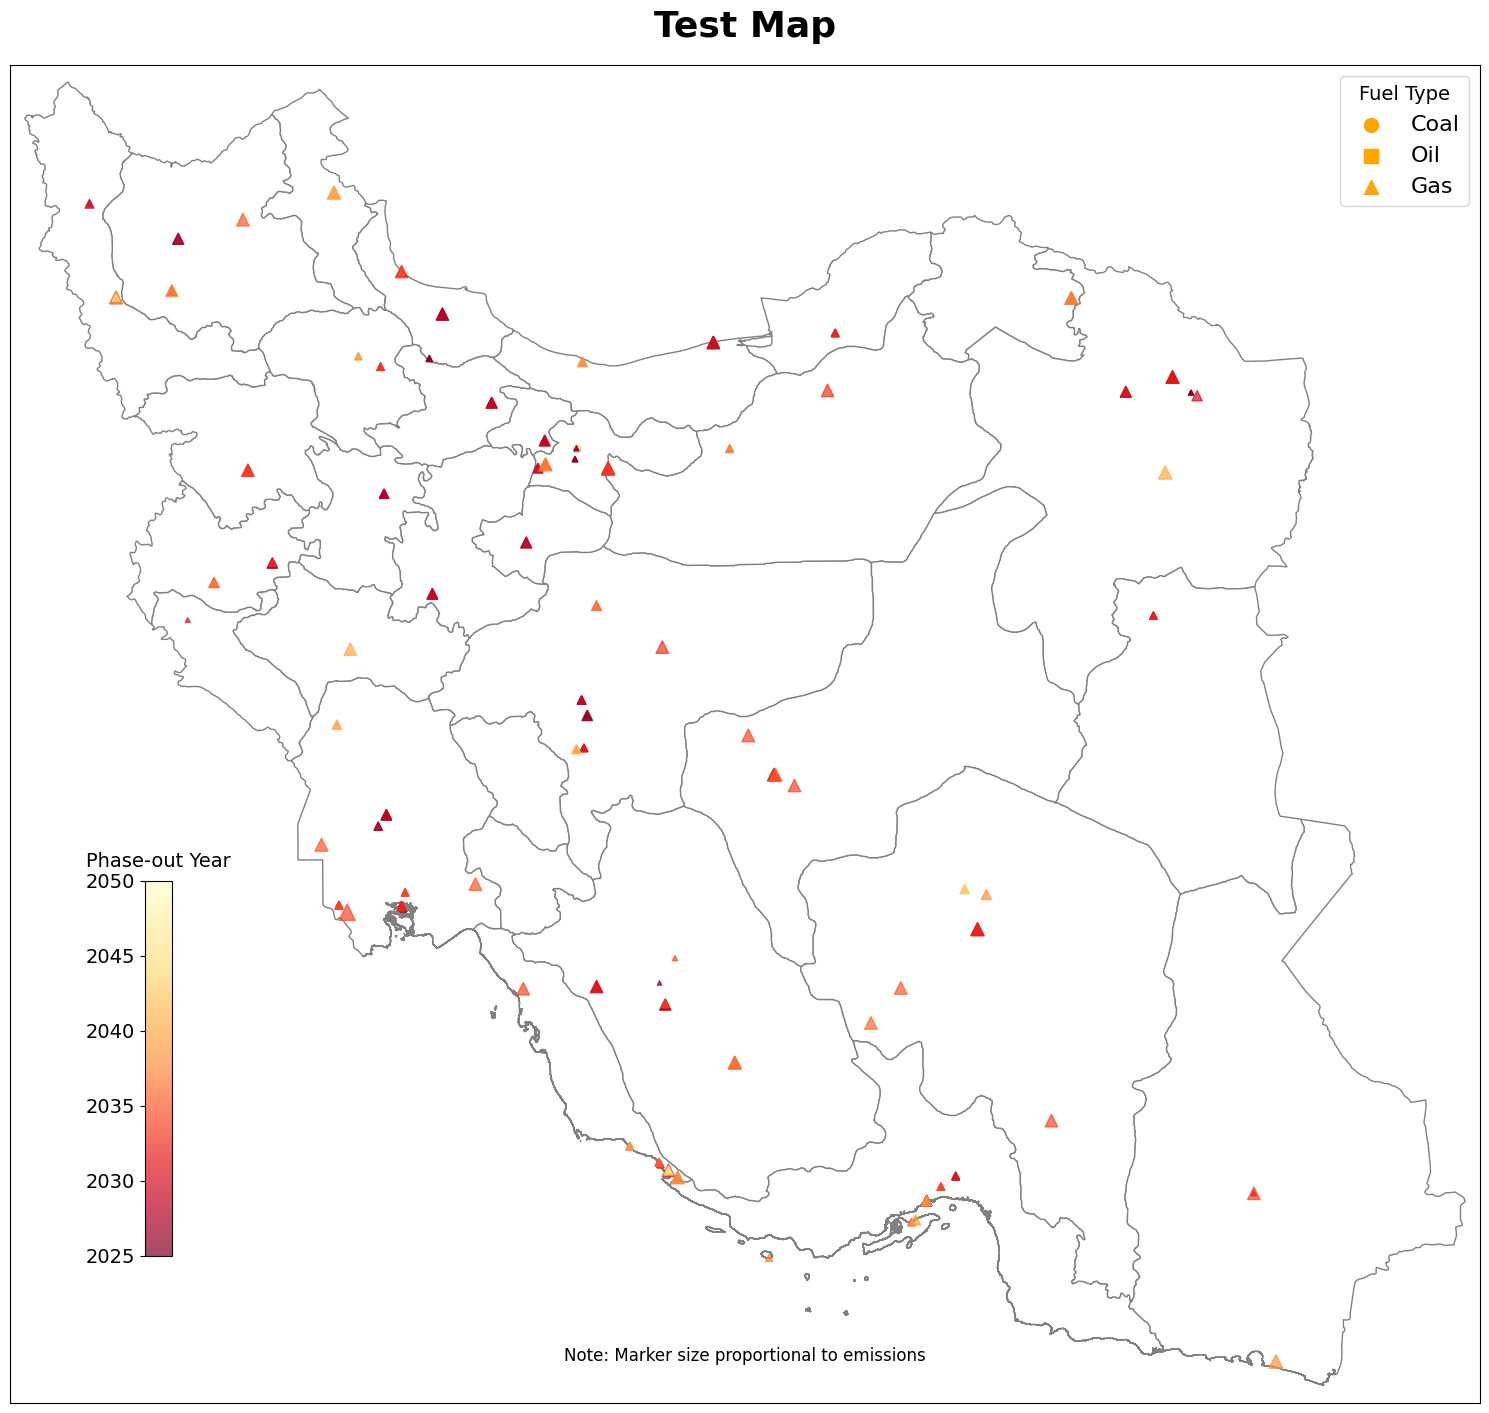

In [158]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def create_phaseout_map(df_merged, title, country_iso3):
   shapefile_path = f'/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_{country_iso3}_shp/gadm41_{country_iso3}_1.shp'
   country = gpd.read_file(shapefile_path)

   fig, ax = plt.subplots(figsize=(15, 15))
   country.plot(ax=ax, color='white', edgecolor='grey')

   markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
   sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

   # Add all markers to legend first
   for subsector in markers.keys():
       ax.scatter([], [], c='orange', marker=markers[subsector], 
                 label=subsector, s=100)  # Empty plot for legend

   # Plot actual data
   for subsector in markers.keys():
       if subsector in df_merged['subsector'].unique():
           mask = df_merged['subsector'] == subsector
           scatter = ax.scatter(
               df_merged[mask]['longitude'], 
               df_merged[mask]['latitude'],
               c=df_merged[mask]['year'],
               cmap='YlOrRd_r',
               marker=markers[subsector],
               s=sizes[mask],
               alpha=0.7,
               vmin=2025,
               vmax=2050
           )

   # TEST DIFFERENT POSITIONS HERE
   cax = fig.add_axes([0.1, 0.15, 0.018, 0.25])  # [x, y, width, height]
   cbar = plt.colorbar(scatter, cax=cax)
   cbar.ax.set_title('Phase-out Year', fontsize=14, pad=10)
   cbar.ax.tick_params(labelsize=14, direction='out')
   cbar.ax.yaxis.set_ticks_position('left')
   cbar.ax.yaxis.set_label_position('left')

   leg = ax.legend(title='Fuel Type', bbox_to_anchor=(1, 1),  # (x, y)
                  fontsize=16, title_fontsize=14)

   plt.figtext(0.5, 0.08,  # (x, y)
               'Note: Marker size proportional to emissions', 
               fontsize=12, ha='center')

   padding = 0.2
   ax.set_xlim([country.total_bounds[0]-padding, country.total_bounds[2]+padding])
   ax.set_ylim([country.total_bounds[1]-padding, country.total_bounds[3]+padding])
   ax.set_title(title, pad=20, fontsize=26, fontweight='bold')
   ax.set_xticks([])
   ax.set_yticks([])

   plt.tight_layout()
   plt.show()
   plt.close()

# Test for one country
country_iso3 = 'IRN'  # Change this to test different countries
df = pd.read_csv(f'/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/v2_power_plant_phaseout_order_by_maturity_IR_2050.csv')
df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)
df_forward_country = df_forward[df_forward['countryiso3'] == country_iso3]

df_merged = df.merge(
   df_forward_country[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude']], 
   on=['asset_name', 'uniqueforwardassetid'],
   how='left'
)

create_phaseout_map(df_merged, 'Test Map', country_iso3)

### India Phase Out Map

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1831526635.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1831526635.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


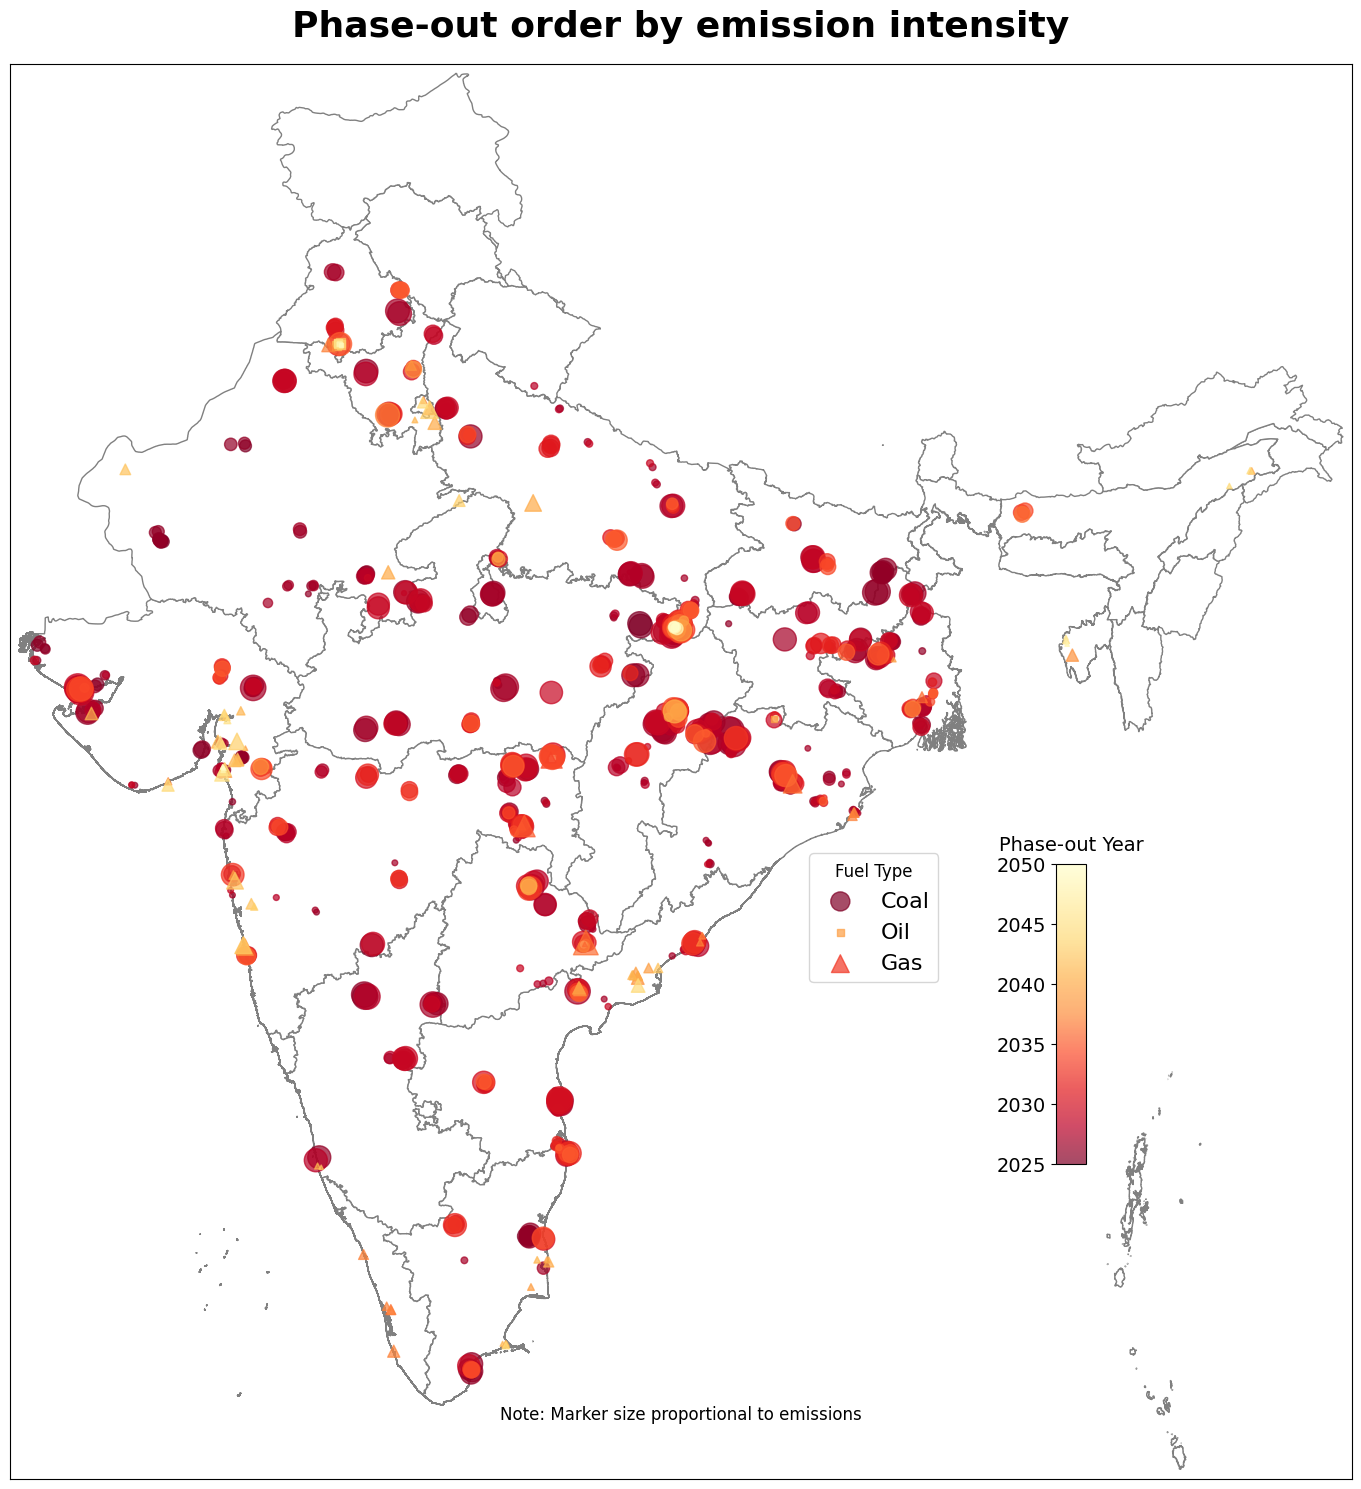

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1831526635.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1831526635.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_merge_data(phase_file):
    df_phase = pd.read_csv(phase_file)
    df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)
    df_forward_in = df_forward[df_forward['countryiso3'] == 'IND']
    
    df_merged = df_phase.merge(
        df_forward_in[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude']], 
        on=['asset_name', 'uniqueforwardassetid'],
        how='left'
    )
    
    # Add jittering to coordinates
    np.random.seed(42)  # For reproducibility
    jitter_scale = 0.03  # Adjust this value to control spread
    df_merged['longitude'] = df_merged['longitude'] + np.random.normal(0, jitter_scale, len(df_merged))
    df_merged['latitude'] = df_merged['latitude'] + np.random.normal(0, jitter_scale, len(df_merged))
    
    return df_merged


def create_phaseout_map(df_merged, title):
   shapefile_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_IND_shp/gadm41_IND_1.shp'
   india = gpd.read_file(shapefile_path)

   fig, ax = plt.subplots(figsize=(15, 15))
   india.plot(ax=ax, color='white', edgecolor='grey')

   markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
   sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

   for subsector in markers.keys():
       if subsector in df_merged['subsector'].unique():
           mask = df_merged['subsector'] == subsector
           scatter = ax.scatter(
               df_merged[mask]['longitude'], 
               df_merged[mask]['latitude'],
               c=df_merged[mask]['year'],
               cmap='YlOrRd_r',
               marker=markers[subsector],
               s=sizes[mask],
               label=subsector,
               alpha=0.7,
               vmin=2025,
               vmax=2050
           )

   # Colorbar
   cax = fig.add_axes([0.75, 0.22, 0.02, 0.2])
   cbar = plt.colorbar(scatter, cax=cax)
   cbar.ax.set_title('Phase-out Year', fontsize=14, pad=10)
   cbar.ax.tick_params(labelsize=14, direction='out')
   cbar.ax.yaxis.set_ticks_position('left')
   cbar.ax.yaxis.set_label_position('left')

   # Legend
   leg = ax.legend(title='Fuel Type', bbox_to_anchor=(0.7, 0.45), 
                  fontsize=16, title_fontsize=12)

   # Marker size note
   plt.figtext(0.5, 0.05, 'Note: Marker size proportional to emissions', 
               fontsize=12, ha='center')

   # Map extent and title
   padding = 0.2
   ax.set_xlim([india.total_bounds[0]-padding, india.total_bounds[2]+padding])
   ax.set_ylim([india.total_bounds[1]-padding, india.total_bounds[3]+padding])
   ax.set_title(title, pad=20, fontsize=26, fontweight='bold')
   ax.set_xticks([])
   ax.set_yticks([])

   plt.tight_layout()
   return fig

base_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/'
files = {
   'maturity': 'v2_power_plant_phaseout_order_by_maturity_IN_2050.csv',
   'emission_factor': 'v2_power_plant_phaseout_order_by_emission_factor_IN_2050.csv',
   'benefits_cost': 'v2_power_plant_phaseout_order_by_emissions_per_opportunity_cost_projection_IN_2050.csv',
   'benefits_cost_maturity': 'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_IN_2050.csv'
}

titles = {
   'maturity': 'Phase-out order by power plant maturity',
   'emission_factor': 'Phase-out order by emission intensity',
   'benefits_cost': 'Phase-out order by benefits/costs (plant maturity not considered)',
   'benefits_cost_maturity': 'Phase-out order by benefits/costs (including plant maturity)'
}

for method, file in files.items():
   df_merged = load_merge_data(base_path + file)
   fig = create_phaseout_map(df_merged, titles[method])
   plt.show()
   plt.close()

KeyError: 'subsector'

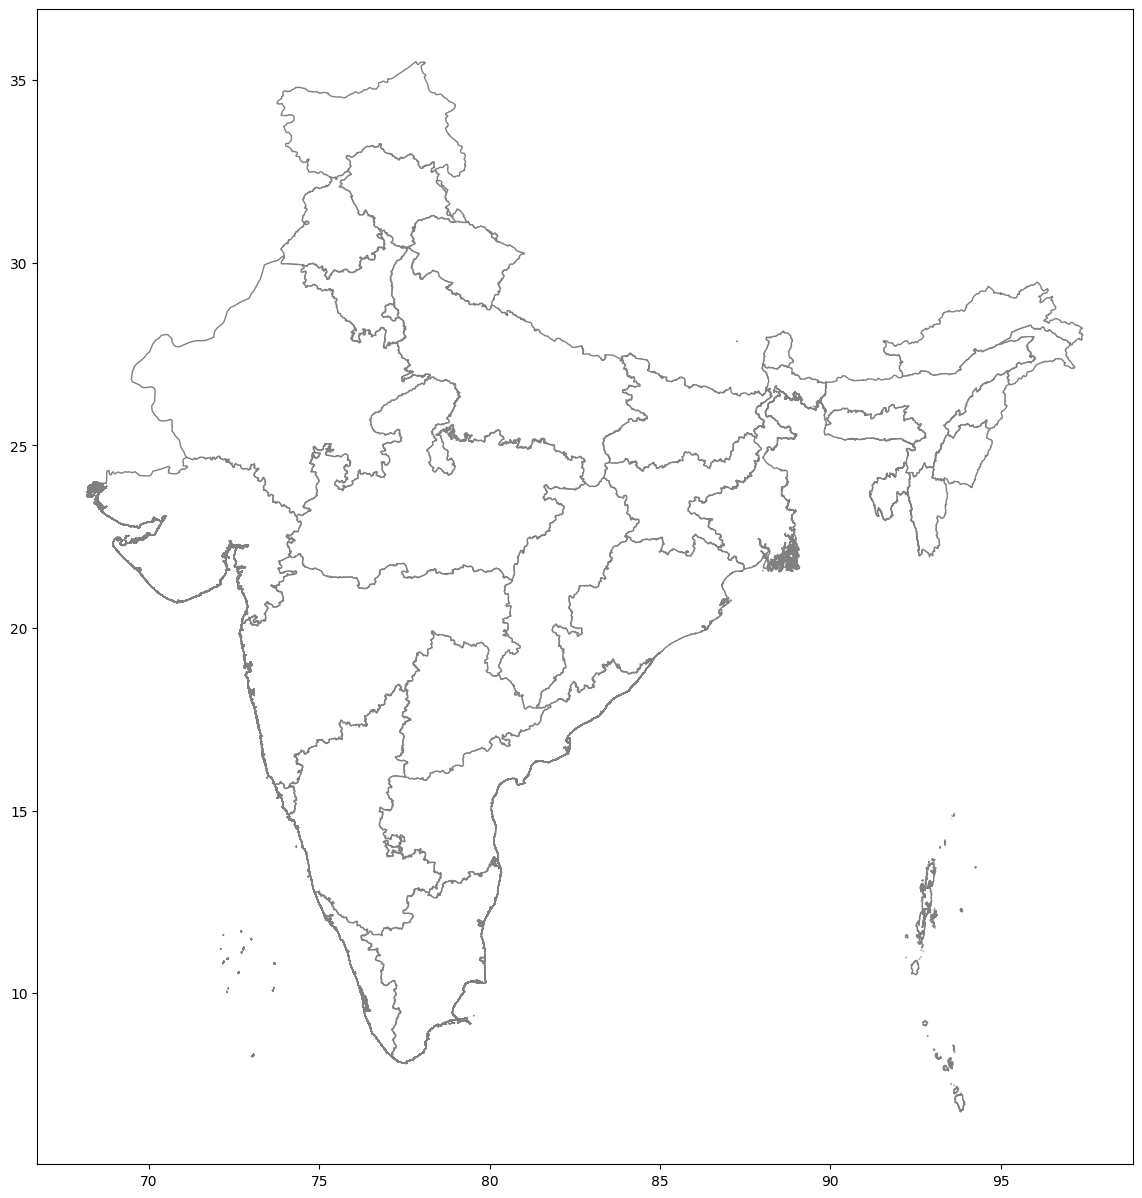

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and merge datasets
def load_merge_data(phase_file):
    df_phase = pd.read_csv(phase_file)
    df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)
    
    df_forward_in = df_forward[df_forward['countryiso3'] == 'IND']
    
    df_merged = df_phase.merge(
        df_forward_in[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude', 'subsector']], 
        on=['asset_name', 'uniqueforwardassetid'],
        how='left'
    )
    return df_merged

def create_phaseout_map(df_merged, title):
    shapefile_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_IND_shp/gadm41_IND_1.shp'
    india = gpd.read_file(shapefile_path)

    fig, ax = plt.subplots(figsize=(15, 15))
    india.plot(ax=ax, color='white', edgecolor='grey')

    markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
    sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

    for subsector in df_merged['subsector'].unique():
        mask = df_merged['subsector'] == subsector
        scatter = ax.scatter(
            df_merged[mask]['longitude'], 
            df_merged[mask]['latitude'],
            c=df_merged[mask]['year'],
            cmap='YlOrRd_r',
            marker=markers[subsector],
            s=sizes[mask],
            label=subsector,
            alpha=0.7,
            vmin=2025,
            vmax=2050
        )

    # Colorbar
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.2])
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.ax.set_title('Phase-out Year', fontsize=12, pad=10)
    cbar.ax.tick_params(labelsize=10, direction='out')
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')

    # Legend
    leg = ax.legend(title='Fuel Type', bbox_to_anchor=(0.85, 0.15), 
                   fontsize=10, title_fontsize=12)

    # Marker size note
    plt.figtext(0.5, 0.05, 'Note: Marker size proportional to emissions', 
                fontsize=10, ha='center')

    # Map extent and title
    padding = 1
    ax.set_xlim([india.total_bounds[0]-padding, india.total_bounds[2]+padding])
    ax.set_ylim([india.total_bounds[1]-padding, india.total_bounds[3]+padding])
    ax.set_title(title, pad=20, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    return fig

# Create maps for each phase-out order
base_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/'
files = {
    'maturity': 'v2_power_plant_phaseout_order_by_maturity_IN_2050.csv',
    'emission_factor': 'v2_power_plant_phaseout_order_by_emission_factor_IN_2050.csv',
    'benefits_cost': 'v2_power_plant_phaseout_order_by_emissions_per_opportunity_cost_projection_IN_2050.csv',
    'benefits_cost_maturity': 'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_IN_2050.csv'
}

titles = {
    'maturity': 'Phase-out order by power plant maturity',
    'emission_factor': 'Phase-out order by emission intensity',
    'benefits_cost': 'Phase-out order by benefits/costs ratio',
    'benefits_cost_maturity': 'Phase-out order by benefits/costs ratio with maturity'
}

for method, file in files.items():
    df_merged = load_merge_data(base_path + file)
    fig = create_phaseout_map(df_merged, titles[method])
    plt.show()
    plt.close()

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(title='Fuel Type', bbox_to_anchor=(0.85, 0.15),
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(title='Fuel Type', bbox_to_anchor=(0.85, 0.15),
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


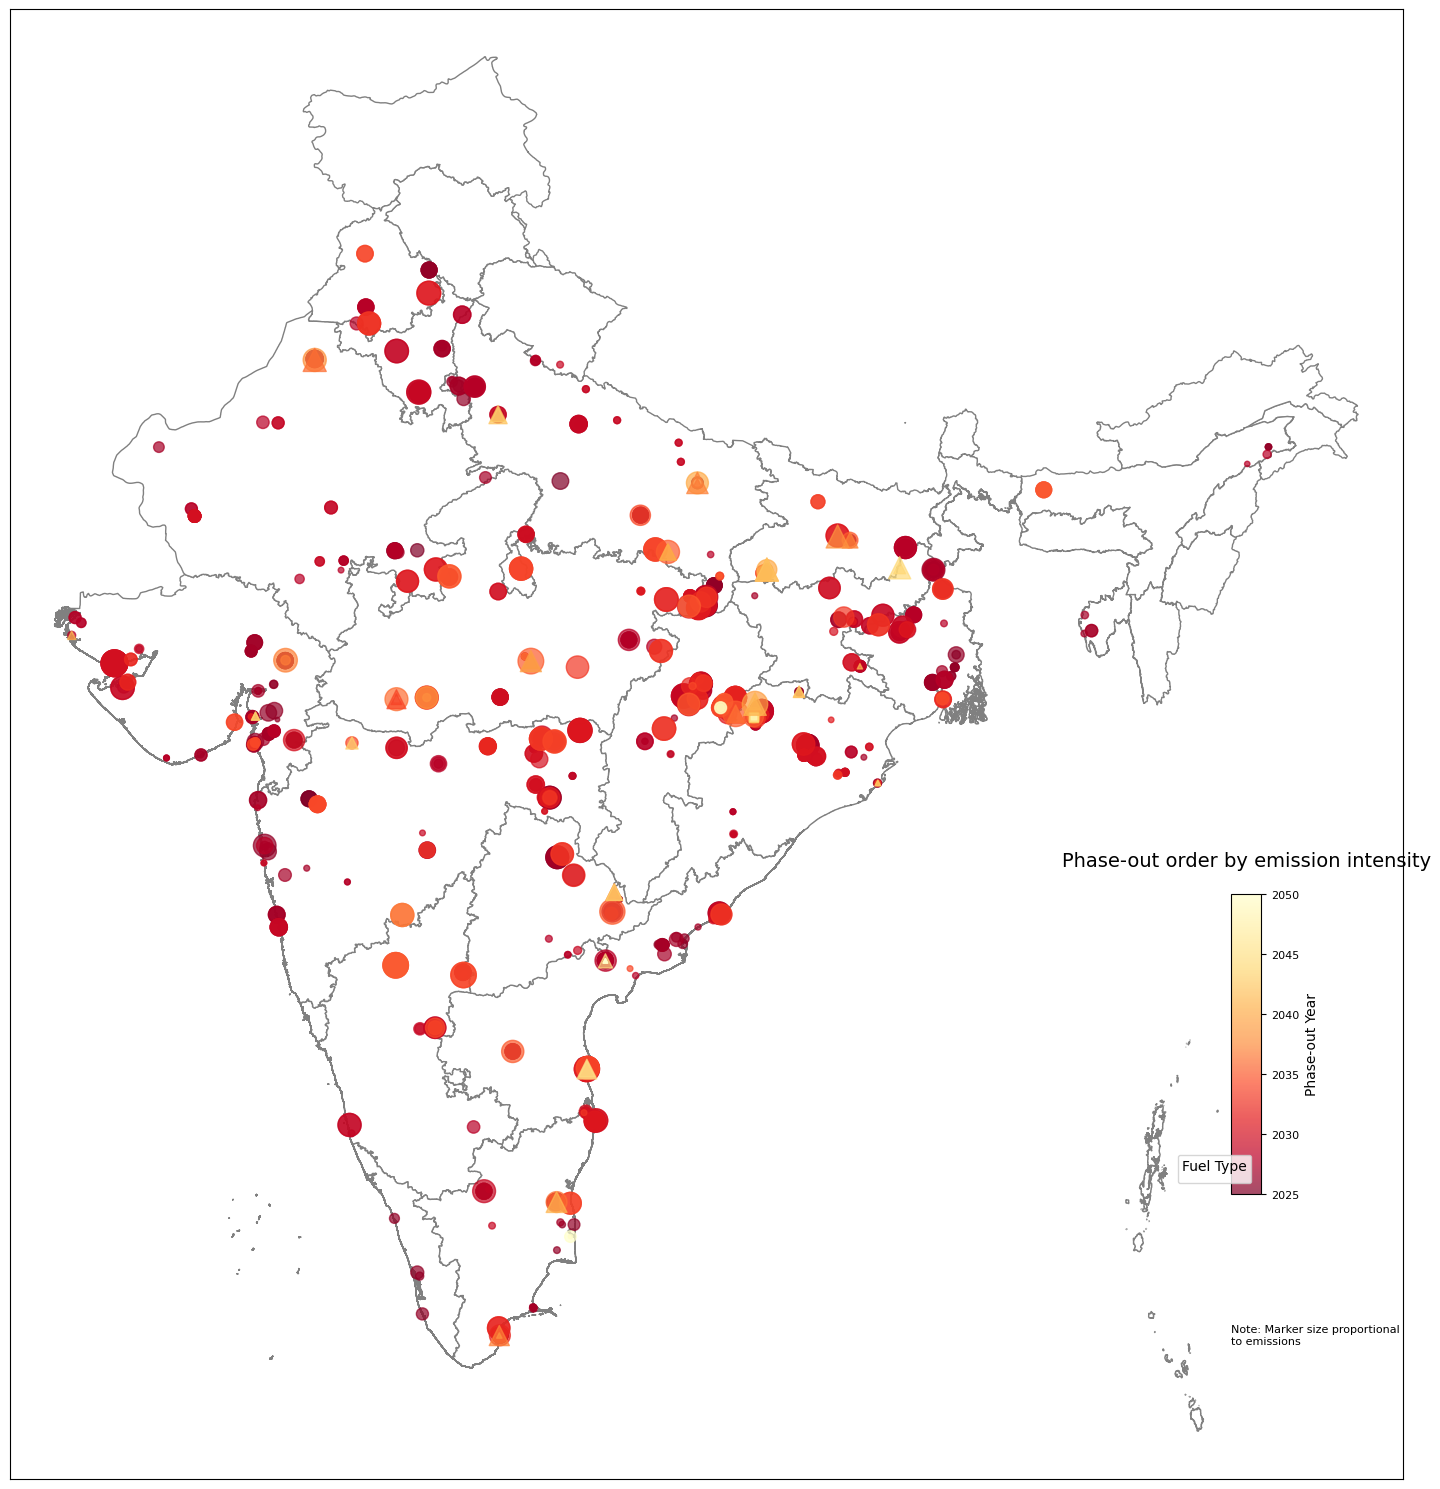

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(title='Fuel Type', bbox_to_anchor=(0.85, 0.15),
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


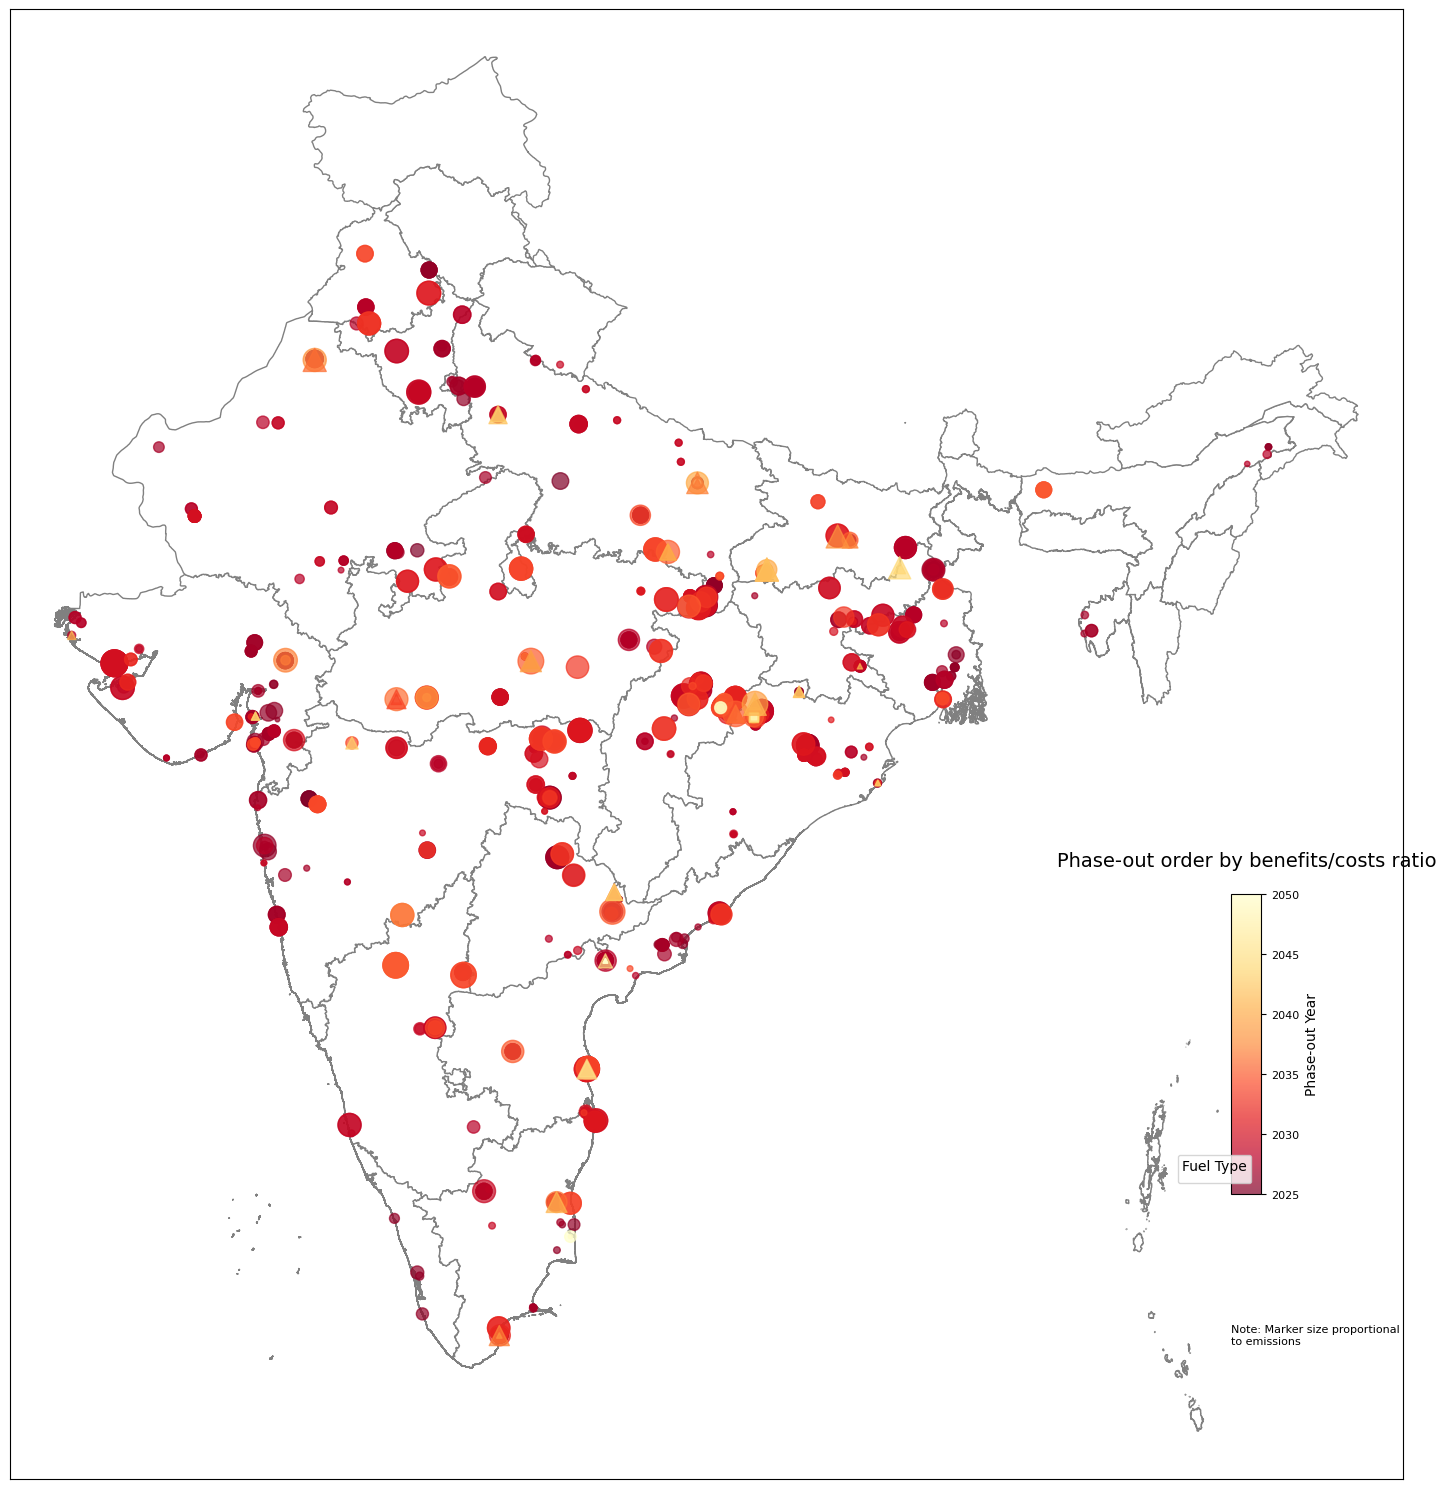

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(title='Fuel Type', bbox_to_anchor=(0.85, 0.15),
/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/1368126437.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


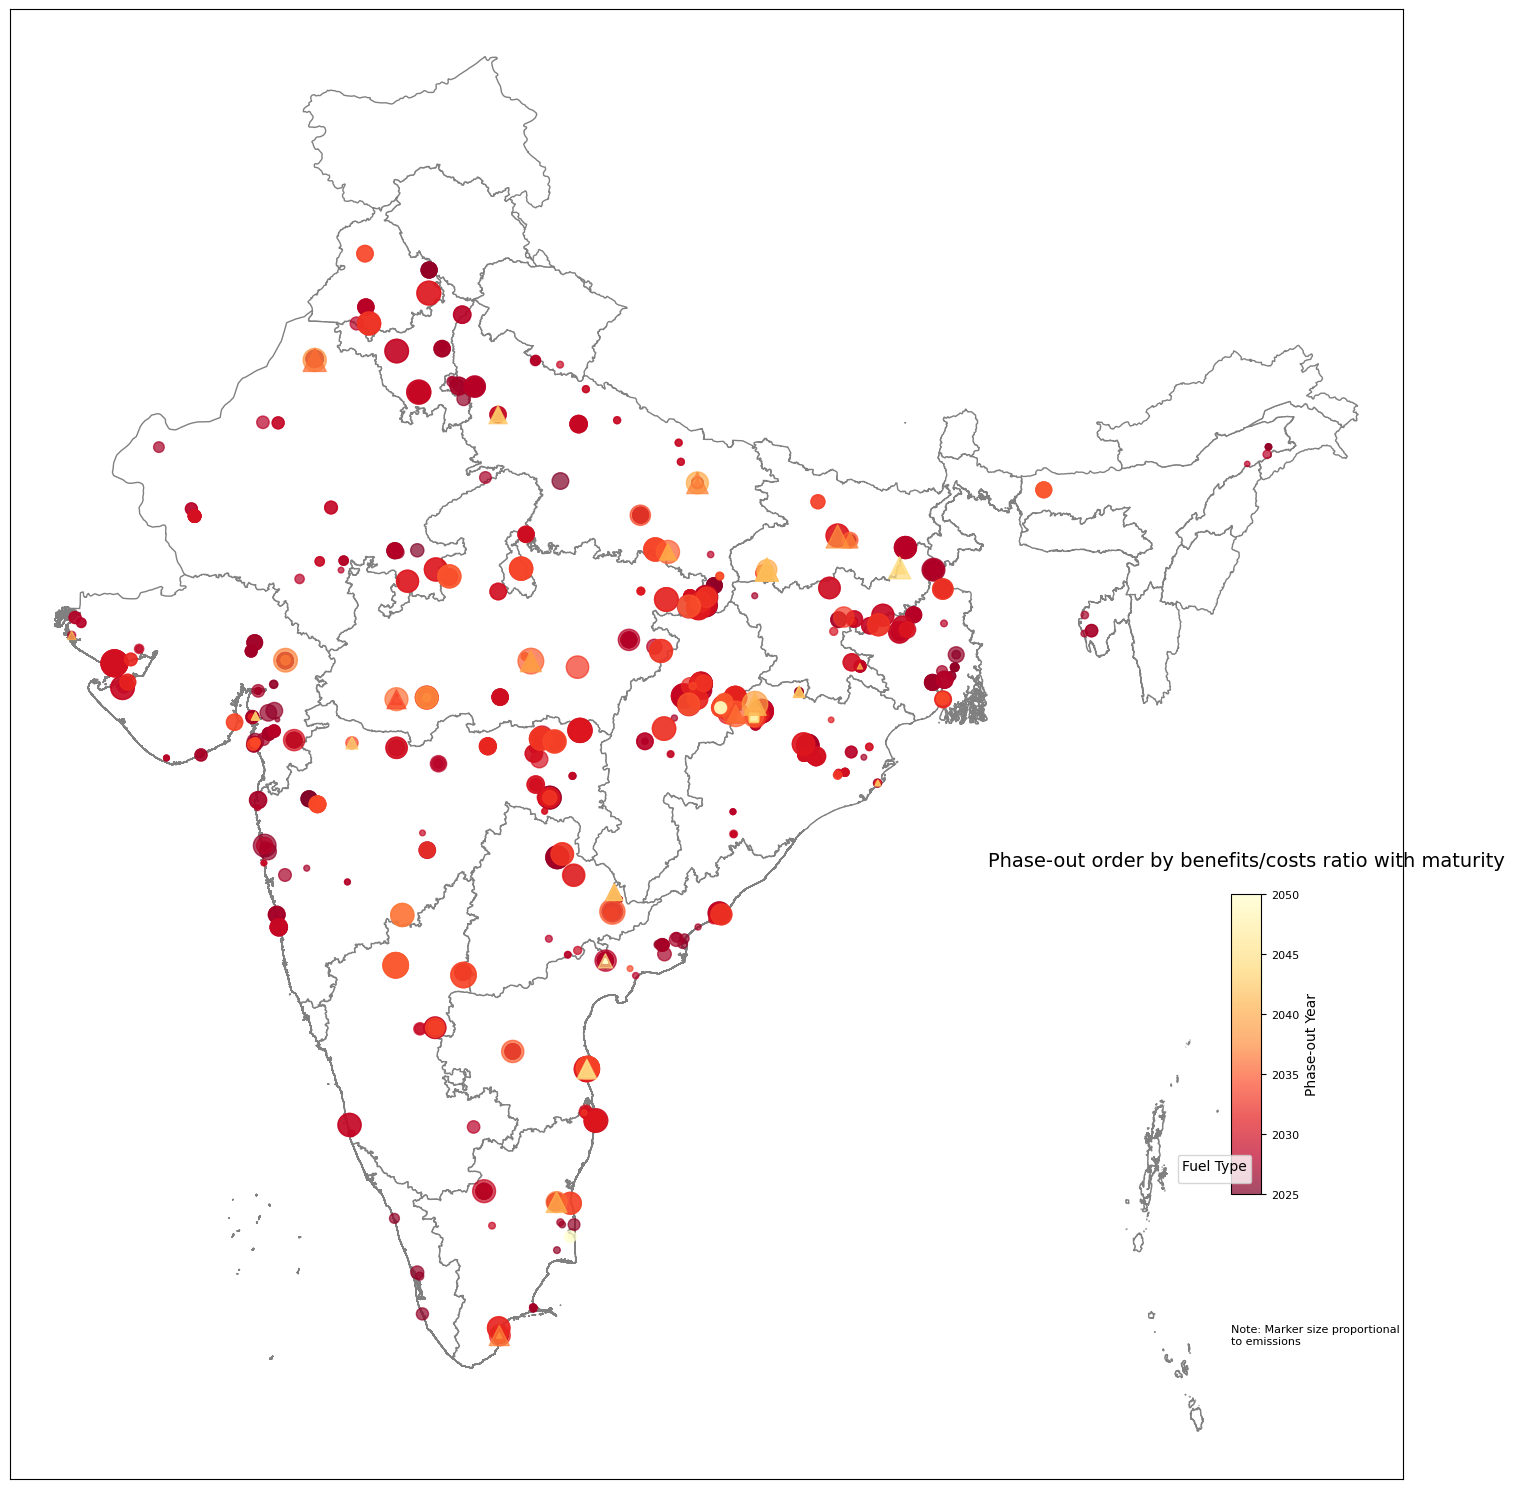

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_phaseout_map(df_merged, title):
    # Load India shapefile
    shapefile_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_IND_shp/gadm41_IND_1.shp'
    india = gpd.read_file(shapefile_path)

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot India
    india.plot(ax=ax, color='white', edgecolor='grey')

    # Create scatter plot for each subsector
    markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
    sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

    for subsector in df_merged['subsector'].unique():
        mask = df_merged['subsector'] == subsector
        scatter = ax.scatter(
            df_merged[mask]['longitude'], 
            df_merged[mask]['latitude'],
            c=df_merged[mask]['year'],
            cmap='YlOrRd_r',  # Reversed colormap
            marker=markers[subsector],
            s=sizes[mask],
            label=subsector,
            alpha=0.7,
            vmin=2025,
            vmax=2050
        )

    # Add colorbar (small, in bottom right)
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.2])
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Phase-out Year', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Add legend (near bottom right)
    leg = plt.legend(title='Fuel Type', bbox_to_anchor=(0.85, 0.15), 
                    fontsize=8, title_fontsize=10)

    # Add marker size note
    plt.figtext(0.85, 0.1, 'Note: Marker size proportional\nto emissions', 
                fontsize=8, ha='left')

    # Set extent and title
    padding = 1
    ax.set_xlim([india.total_bounds[0]-padding, india.total_bounds[2]+padding])
    ax.set_ylim([india.total_bounds[1]-padding, india.total_bounds[3]+padding])
    plt.title(title, pad=20, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    return fig

# Create maps for each phase-out order
base_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/'
files = {
    'maturity': 'v2_power_plant_phaseout_order_by_maturity_IN_2050.csv',
    'emission_factor': 'v2_power_plant_phaseout_order_by_emission_factor_IN_2050.csv',
    'benefits_cost': 'v2_power_plant_phaseout_order_by_emissions_per_opportunity_cost_projection_IN_2050.csv',
    'benefits_cost_maturity': 'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_IN_2050.csv'
}

titles = {
    'maturity': 'Phase-out order by power plant maturity',
    'emission_factor': 'Phase-out order by emission intensity',
    'benefits_cost': 'Phase-out order by benefits/costs ratio',
    'benefits_cost_maturity': 'Phase-out order by benefits/costs ratio with maturity'
}

for method, file in files.items():
    df = pd.read_csv(base_path + file)
    fig = create_phaseout_map(df_merged, titles[method])
    plt.show()
    plt.close()

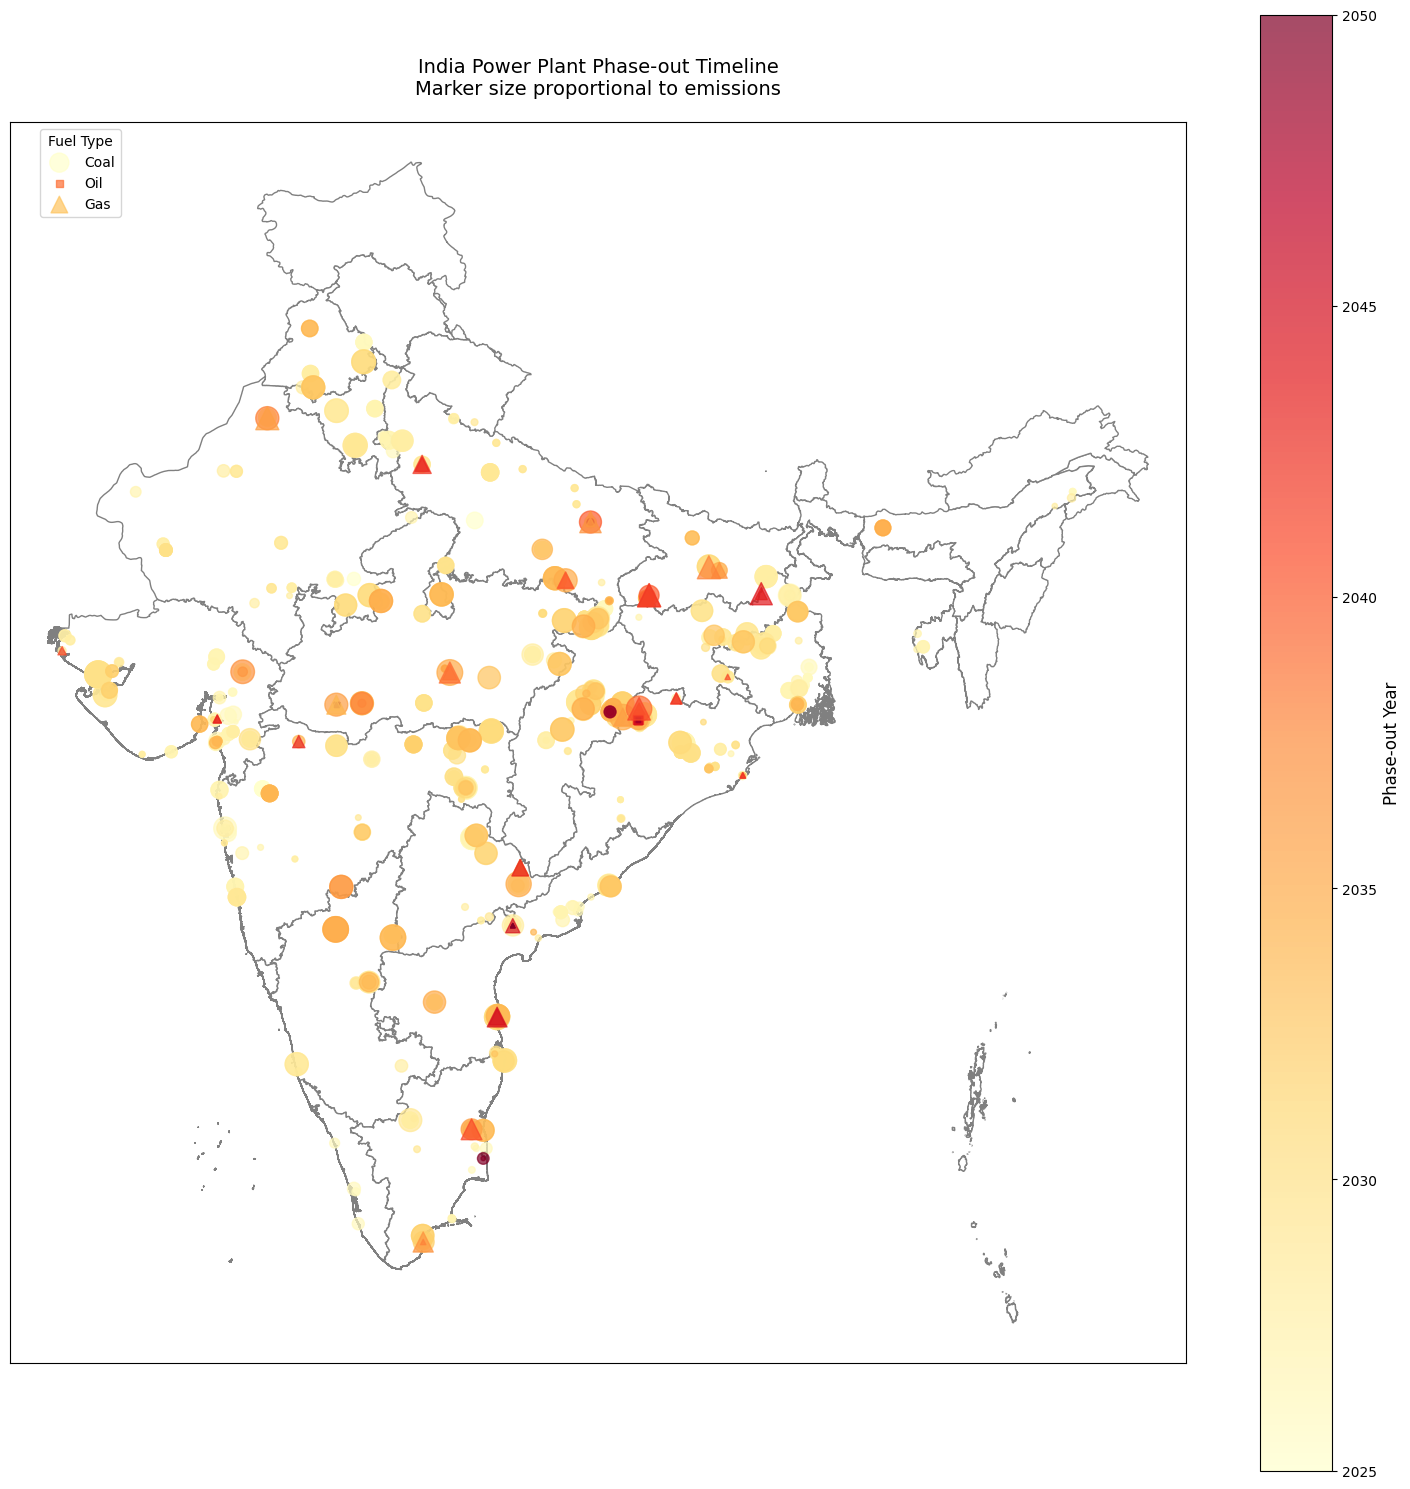

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load India shapefile
shapefile_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_IND_shp/gadm41_IND_1.shp'
india = gpd.read_file(shapefile_path)

# Create plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot India
india.plot(ax=ax, color='white', edgecolor='grey')

# Create scatter plot for each subsector
markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

for subsector in df_merged['subsector'].unique():
    mask = df_merged['subsector'] == subsector
    scatter = ax.scatter(
        df_merged[mask]['longitude'], 
        df_merged[mask]['latitude'],
        c=df_merged[mask]['year'],
        cmap='YlOrRd',
        marker=markers[subsector],
        s=sizes[mask],
        label=subsector,
        alpha=0.7,
        vmin=2025,
        vmax=2050
    )

# Add colorbar and legend
cbar = plt.colorbar(scatter)
cbar.set_label('Phase-out Year', fontsize=12)
plt.legend(title='Fuel Type', bbox_to_anchor=(0.1, 1), fontsize=10)

# Set extent and title
padding = 1
ax.set_xlim([india.total_bounds[0]-padding, india.total_bounds[2]+padding])
ax.set_ylim([india.total_bounds[1]-padding, india.total_bounds[3]+padding])
plt.title('India Power Plant Phase-out Timeline\nMarker size proportional to emissions', pad=20, fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

# Load both datasets
df_phase = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/v2_power_plant_phaseout_order_by_maturity_IN_2050.csv')
df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)

# Filter Forward data for India
df_forward_in = df_forward[df_forward['countryiso3'] == 'IND']

# Merge datasets on asset_name and uniqueforwardassetid
df_merged = df_phase.merge(
    df_forward_in[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude']], 
    on=['asset_name', 'uniqueforwardassetid'],
    how='left'
)

# Check results
print("Merge Results:")
print(f"Original phase-out rows: {len(df_phase)}")
print(f"Merged rows: {len(df_merged)}")
print(f"Rows with missing coordinates: {df_merged['latitude'].isna().sum()}")

# Display sample of merged data
print("\nSample of merged data:")
print(df_merged[['asset_name', 'latitude', 'longitude', 'year', 'amount_mtco2']].head())

Merge Results:
Original phase-out rows: 976
Merged rows: 976
Rows with missing coordinates: 0

Sample of merged data:
                     asset_name   latitude  longitude  year  amount_mtco2
0  Bandel Thermal Power Station  22.995747  88.403816  2025          0.37
1         Nellore power station  14.490572  79.986946  2025          0.19
2       Renusagar power station  24.181093  82.791283  2025          0.42
3       Renusagar power station  24.181093  82.791283  2025          0.42
4    Ramagundam-B power station  18.754999  79.456108  2025          0.39


In [3]:
import pandas as pd

# Load Forward Analytics dataset
df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv')

# Basic dataset info
print("Dataset Overview:")
print("-----------------")
print(f"Shape: {df_forward.shape}")
print("\nColumns:", df_forward.columns.tolist())
print("\nFirst few rows of asset_name:")
print(df_forward['asset_name'].head())

# Check for any missing values in asset_name
print("\nMissing values in asset_name:", df_forward['asset_name'].isnull().sum())

Dataset Overview:
-----------------
Shape: (125915, 46)

Columns: ['forwardcompanyid', 'directownerfirm', 'uniqueforwardassetid', 'originalrawsource', 'asset_name', 'asset_unit', 'sector', 'subsector', 'technology_type', 'technology_subtype', 'technology_sub_subtype', 'countryiso3', 'latitude', 'longitude', 'emission_factor', 'emission_factor_unit', 'heat_rate', 'heat_rate_unit', 'annualco2tyear', 'lifetimeco2', 'capacity', 'capacity_unit', 'capacity_factor', 'activity_unit', 'activity_type', 'activity_year', 'status', 'status_details', 'status_year', 'start_year', 'retired_year', 'planned_retirement', 'captive', 'captive_industry', 'hydrogen_capable_yn', 'ccs_attachement', 'operator', 'annual_co2_calc', 'fuel_group', 'asset_location', 'levelofdevelopment', 'country_name', 'gca_region', 'used_capacity', 'activity', 'asset_id']

First few rows of asset_name:
0                Jiangxi Anfu power station
1       Welkait Sugar Factory power station
2             Guangxi Xing'An power statio

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_23880/3621523765.py:4: DtypeWarning: Columns (9,15,17,23,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explore_phase_out_data(country_code='IN', base_path='/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data'):
    file_patterns = {
        'maturity': f'v2_power_plant_phaseout_order_by_maturity_{country_code}_2050.csv',
        'emission_factor': f'v2_power_plant_phaseout_order_by_emission_factor_{country_code}_2050.csv',
        'benefits_cost': f'v2_power_plant_phaseout_order_by_emissions_per_opportunity_cost_projection_{country_code}_2050.csv',
        'benefits_cost_maturity': f'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_{country_code}_2050.csv'
    }
    
    # Load maturity-based phaseout as example
    file_path = f"{base_path}/{file_patterns['maturity']}"
    df = pd.read_csv(file_path)
    
    # Basic dataset info
    print("Dataset Overview:")
    print("-----------------")
    print(f"Shape: {df.shape}")
    print("\nColumns:", df.columns.tolist())
    
    # Check unique values in key columns
    print("\nUnique Values:")
    print("-----------------")
    print("Years:", sorted(df['year'].unique()))
    print("Subsectors:", df['subsector'].unique())
    
    # Emissions summary by year and subsector
    print("\nYearly Emissions by Subsector:")
    print("-----------------")
    yearly_subsector = df.pivot_table(
        values='amount_mtco2',
        index='year',
        columns='subsector',
        aggfunc='sum'
    )
    print(yearly_subsector)

    return df

# Run exploration
df = explore_phase_out_data()

Dataset Overview:
-----------------
Shape: (976, 8)

Columns: ['uniqueforwardassetid', 'asset_name', 'subsector', 'fraction', 'amount_mtco2', 'oc_owner', 'score', 'year']

Unique Values:
-----------------
Years: [np.int64(2025), np.int64(2026), np.int64(2027), np.int64(2028), np.int64(2029), np.int64(2030), np.int64(2031), np.int64(2032), np.int64(2033), np.int64(2034), np.int64(2035), np.int64(2036), np.int64(2037), np.int64(2038), np.int64(2039), np.int64(2040), np.int64(2041), np.int64(2042), np.int64(2043), np.int64(2044), np.int64(2045), np.int64(2046), np.int64(2047), np.int64(2048), np.int64(2049), np.int64(2050)]
Subsectors: ['Coal' 'Oil' 'Gas']

Yearly Emissions by Subsector:
-----------------
subsector        Coal       Gas       Oil
year                                     
2025        27.040755       NaN       NaN
2026       196.018975       NaN       NaN
2027       179.591976       NaN       NaN
2028       162.775616       NaN       NaN
2029       145.507679       NaN     